In [1]:
import sys
sys.path.append("models/raster")

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from auxiliary.visualization import visualize_losses, visualize_confusion_matrix
from auxiliary.misc import send_notification, get_model_name

from cnn import CNN
from vit import ViT
from dataset_raster import BuildingRasterDataset
from train_raster import train_raster_model
from metrics_raster import get_metrics_raster

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, then MPS, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    raster_path = "../scratch/raster"
else:
    device = torch.device("cpu")
    # local path
    raster_path = "../data.nosync/raster"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")

In [5]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

## Elimination model

In [6]:
# define path to training and validation data
path_to_training_data = os.path.join(raster_path, "training_data", "elimination", "training")
path_to_validation_data = os.path.join(raster_path, "training_data", "elimination", "validation")
path_to_test_data = os.path.join(raster_path, "training_data", "elimination", "test")

# define input parameters
elimination_operators = ["elimination"]
attach_roads = True

n_channels = 3 if attach_roads else 2
n_classes = len(elimination_operators)

# Creating model and moving to device
model = CNN(n_channels=n_channels, n_classes=n_classes)
#model = ViT(channels=n_channels, num_classes=n_classes, heads=8)

model.to(device)
print(f"Using {model}")

learning_rate = 0.0005

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using CNN with 4,075,585 parameters


In [7]:
# composing various random transforms that should be applied to the data
transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(0,0)),
        transforms.RandomRotation(degrees=(90,90)),
        transforms.RandomRotation(degrees=(180,180)),
        transforms.RandomRotation(degrees=(270,270))
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

# construct training Dataset
training_set = BuildingRasterDataset(path_to_training_data, 
                                     operators=elimination_operators, 
                                     attach_roads=attach_roads, 
                                     transform=transform, 
                                     subset=1000)

# construct validation Dataset (no shuffling)
validation_set = BuildingRasterDataset(path_to_validation_data, 
                                       operators=elimination_operators, 
                                       attach_roads=attach_roads, 
                                       transform=transform,
                                       subset=1000)

# construct test Dataset (no transformations, no shuffling)
test_set = BuildingRasterDataset(path_to_test_data, 
                                 operators=elimination_operators, 
                                 attach_roads=attach_roads, 
                                 transform=None,
                                 subset=1000)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
1,000 samples in the validation set.
1,000 samples in the test set.


### Model training

In [8]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

# training the model
model, training_losses, validation_losses, training_time = train_raster_model(model=model, 
                                                                              device=device, 
                                                                              optimizer=optimizer, 
                                                                              criterion=criterion, 
                                                                              n_epochs=n_epochs, 
                                                                              batch_size=batch_size, 
                                                                              validate=True, 
                                                                              training_set=training_set, 
                                                                              validation_set=validation_set, 
                                                                              shuffle_training_set=True, 
                                                                              shuffle_validation_set=False)

# saving the losses
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
losses_path = os.path.join(raster_path, "model_outputs", "elimination", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=training_time)

epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.695, validation loss: 0.693
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.694, validation loss: 0.692
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.693, validation loss: 0.692
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4/10, step 18/63
epoch 4/10, step 24/63
epoch 4/10, step 30/63
epoch 4/10

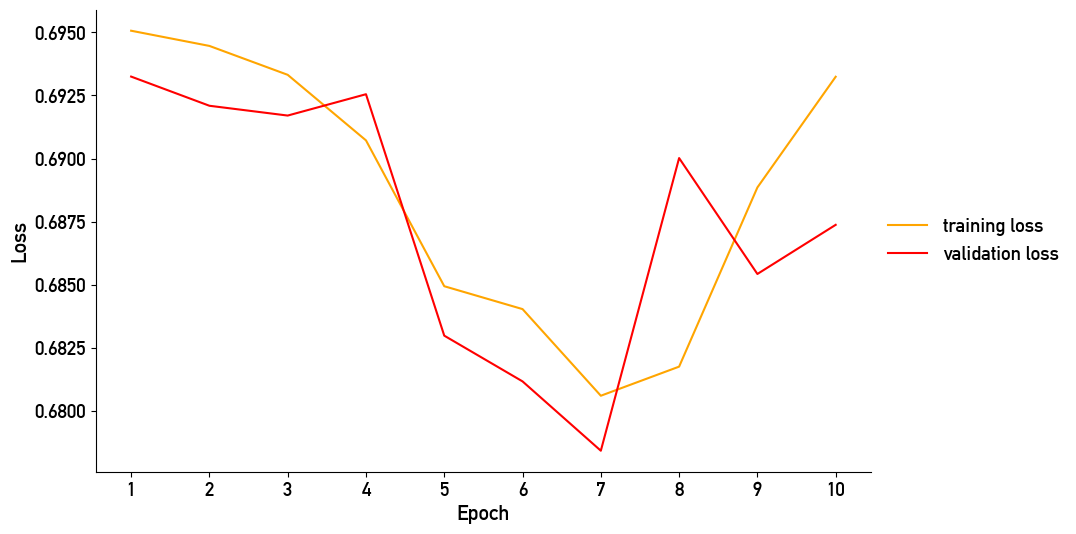

In [9]:
loss_path = os.path.join(raster_path, "model_outputs", "elimination", "losses")
visualize_losses([model_name], loss_path)

In [10]:
# save the trained model to disk
path_to_models = os.path.join(raster_path, "models", "elimination")

model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

### Accuracy metrics after training

In [11]:
# loading the trained model
model_path = os.path.join(raster_path, "models", "elimination")
#model_name = ""
model = CNN(n_channels=3, n_classes=1)
#model_name = ""
#model = ViT(channels=3, num_classes=4, heads=8)
checkpoint = torch.load(os.path.join(model_path, model_name), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model successfully loaded.")

Model successfully loaded.


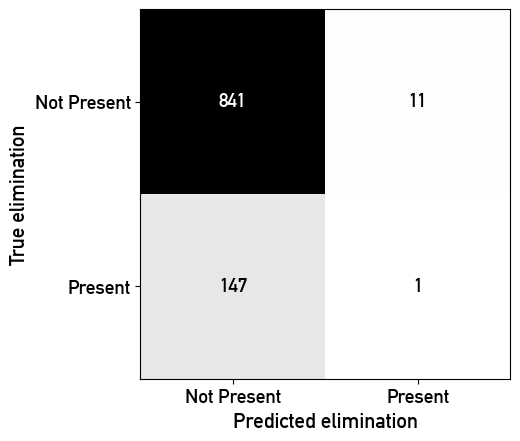

Accuracy: 0.842
Precision: 0.083
Recall: 0.007
F1 Score: 0.013


In [12]:
# calculate accuracy metrics
metrics = get_metrics_raster(model=model, 
                             dataset=test_set,
                             batch_size=len(test_set),
                             operators_to_pred=elimination_operators, 
                             threshold=0.5,
                             device=device)

# saving the accuracy metrics
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
metrics_path = os.path.join(raster_path, "model_outputs", "elimination", "metrics", model_name)

# creating a DataFrame with accuracy metrics
metrics_df = pd.DataFrame({"operator": metrics["operator"],
                           "accuracy": metrics["accuracy"], 
                           "precision": metrics["precision"],
                           "recall": metrics["recall"],
                           "f1-score": metrics["f1_score"]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# print the results
for i in range(len(elimination_operators)):
    # display the confusion matrix
    visualize_confusion_matrix(metrics["conf_matrix"][i], operator=metrics["operator"][i])

    # print metrics
    print(f"Accuracy: {metrics['accuracy'][i]:.3f}")
    print(f"Precision: {metrics['precision'][i]:.3f}")
    print(f"Recall: {metrics['recall'][i]:.3f}")
    print(f"F1 Score: {metrics['f1_score'][i]:.3f}")

## Selection model

In [13]:
# define path to training and validation data
path_to_training_data = os.path.join(raster_path, "training_data", "selection", "training")
path_to_validation_data = os.path.join(raster_path, "training_data", "selection", "validation")
path_to_test_data = os.path.join(raster_path, "training_data", "selection", "test")

# define input parameters
selection_operators = ["aggregation", "typification", "displacement", "enlargement"]
attach_roads = True

n_channels = 3 if attach_roads else 2
n_classes = len(selection_operators)

# Creating model and moving to device
model = CNN(n_channels=n_channels, n_classes=n_classes)
#model = ViT(channels=n_channels, num_classes=n_classes, heads=8)

model.to(device)
print(f"Using {model}")

learning_rate = 0.0005

criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using CNN with 8,893,252 parameters


In [14]:
# composing various random transforms that should be applied to the data
transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(0,0)),
        transforms.RandomRotation(degrees=(90,90)),
        transforms.RandomRotation(degrees=(180,180)),
        transforms.RandomRotation(degrees=(270,270))
    ]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

# construct training Dataset
training_set = BuildingRasterDataset(path_to_training_data, 
                                     operators=selection_operators, 
                                     attach_roads=attach_roads, 
                                     transform=transform,
                                     subset=1000)

# construct validation Dataset (no shuffling)
validation_set = BuildingRasterDataset(path_to_validation_data, 
                                       operators=selection_operators, 
                                       attach_roads=attach_roads, 
                                       transform=transform,
                                       subset=1000)

# construct test Dataset (no transformations, no shuffling)
test_set = BuildingRasterDataset(path_to_test_data, 
                                 operators=selection_operators, 
                                 attach_roads=attach_roads, 
                                 transform=None,
                                 subset=1000)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
1,000 samples in the validation set.
1,000 samples in the test set.


### Model training

In [15]:
# number of epochs and batch size
n_epochs = 10
batch_size = 16

# training the model
model, training_losses, validation_losses, training_time = train_raster_model(model=model, 
                                                                              device=device, 
                                                                              optimizer=optimizer, 
                                                                              criterion=criterion, 
                                                                              n_epochs=n_epochs, 
                                                                              batch_size=batch_size, 
                                                                              validate=True, 
                                                                              training_set=training_set, 
                                                                              validation_set=validation_set, 
                                                                              shuffle_training_set=True, 
                                                                              shuffle_validation_set=False)

# saving the losses
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
losses_path = os.path.join(raster_path, "model_outputs", "selection", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=training_time)

epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.689, validation loss: 0.692
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.685, validation loss: 0.678
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.675, validation loss: 0.663
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4/10, step 18/63
epoch 4/10, step 24/63
epoch 4/10, step 30/63
epoch 4/10

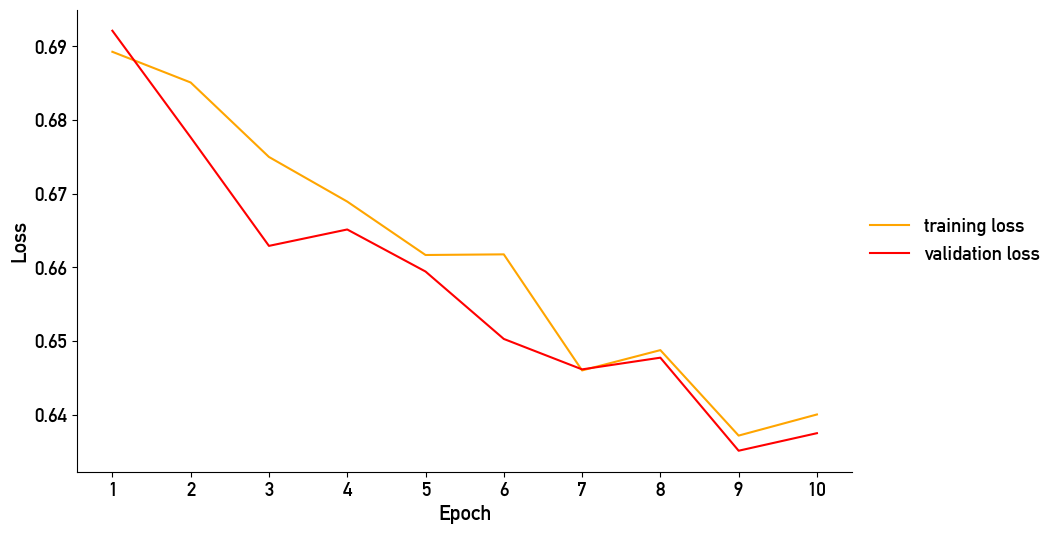

In [16]:
loss_path = os.path.join(raster_path, "model_outputs", "selection", "losses")
visualize_losses([model_name], loss_path)

In [17]:
# save the trained model to disk
path_to_models = os.path.join(raster_path, "models", "selection")

model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

### Accuracy metrics after training

In [18]:
# loading the trained model
model_path = os.path.join(raster_path, "models", "selection")
#model_name = ""
model = CNN(n_channels=3, n_classes=4)
#model_name = ""
#model = ViT(channels=3, num_classes=4, heads=8)
checkpoint = torch.load(os.path.join(model_path, model_name), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model successfully loaded.")

Model successfully loaded.


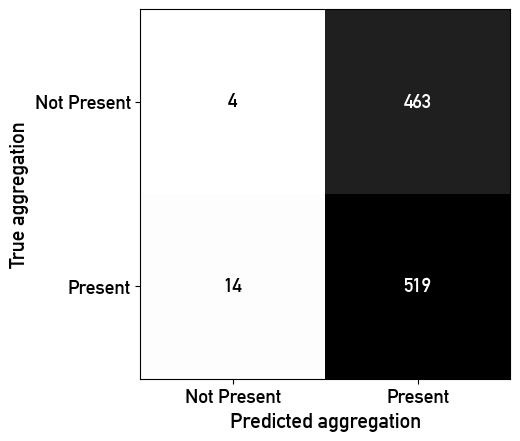

Accuracy: 0.523
Precision: 0.529
Recall: 0.974
F1 Score: 0.685


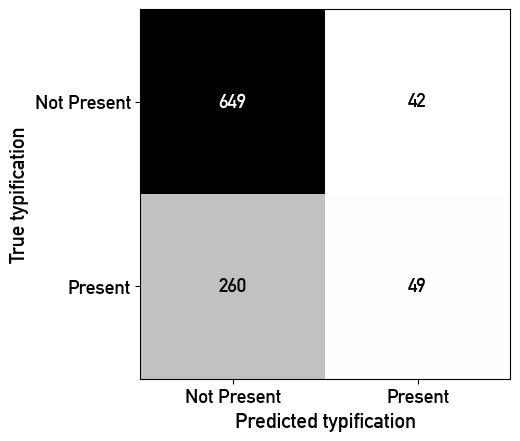

Accuracy: 0.698
Precision: 0.538
Recall: 0.159
F1 Score: 0.245


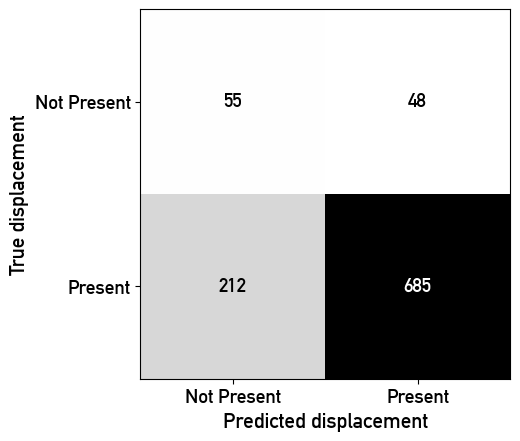

Accuracy: 0.740
Precision: 0.935
Recall: 0.764
F1 Score: 0.840


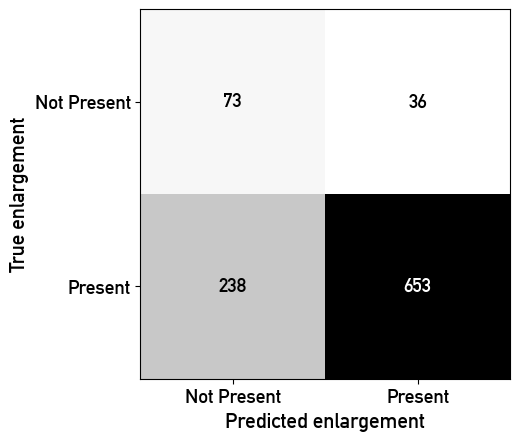

Accuracy: 0.726
Precision: 0.948
Recall: 0.733
F1 Score: 0.827


In [19]:
# calculate accuracy metrics
metrics = get_metrics_raster(model=model, 
                             dataset=test_set,
                             batch_size=len(test_set),
                             operators_to_pred=selection_operators, 
                             threshold=0.5,
                             device=device)

# saving the accuracy metrics
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
metrics_path = os.path.join(raster_path, "model_outputs", "selection", "metrics", model_name)

# creating a DataFrame with accuracy metrics
metrics_df = pd.DataFrame({"operator": metrics["operator"],
                           "accuracy": metrics["accuracy"], 
                           "precision": metrics["precision"],
                           "recall": metrics["recall"],
                           "f1-score": metrics["f1_score"]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# print the results
for i in range(len(selection_operators)):
    # display the confusion matrix
    visualize_confusion_matrix(metrics["conf_matrix"][i], operator=metrics["operator"][i])

    # print metrics
    print(f"Accuracy: {metrics['accuracy'][i]:.3f}")
    print(f"Precision: {metrics['precision'][i]:.3f}")
    print(f"Recall: {metrics['recall'][i]:.3f}")
    print(f"F1 Score: {metrics['f1_score'][i]:.3f}")